# GM Model Pattern Animation

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Forward Euler Method

In [2]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 0.25
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Initial condition
np.random.seed(9001)
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern using own laplace function
for i in range(1, time_steps):
    U[i] = Du * c * my_laplacian(U[i - 1])
    V[i] = Dv * c * my_laplacian(V[i - 1])

    U[i] += dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - dt * mu_u) * U[i - 1] + dt * rho_u
    V[i] += dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - dt * mu_v) * V[i - 1]

dt = 0.25, time_steps = 40000


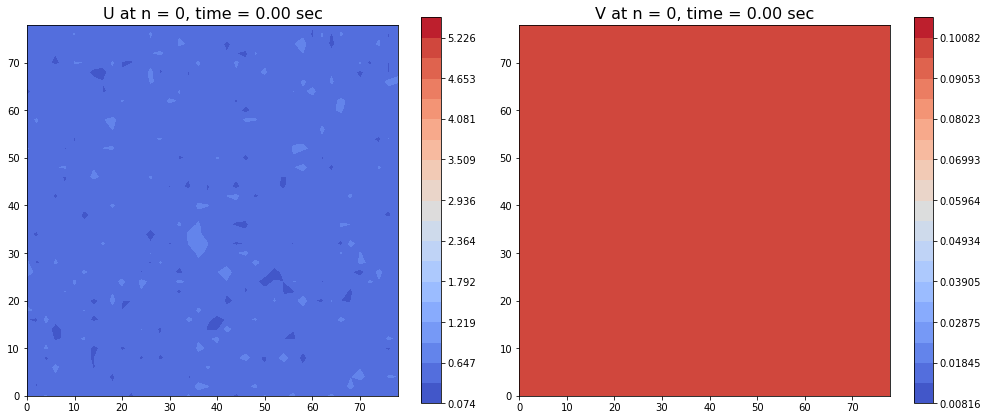

In [3]:
ani = animate_pattern(U, V, h, dt, Nsteps=time_steps, Nout=1000)
HTML(ani.to_html5_video())

## Backward Euler Method

In [4]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - Du * c * L
Tv = sparse.eye(N) - Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
np.random.seed(9001)
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

# Backward Euler
for i in range(1, time_steps):
    bU = dt * rho/V1d[i - 1] * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_u) * U1d[i - 1] + dt * rho_u
    U1d[i] = solve_Tu(bU)

    bV = dt * rho * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_v) * V1d[i - 1]
    V1d[i] = solve_Tv(bV)

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

dt = 20, time_steps = 500


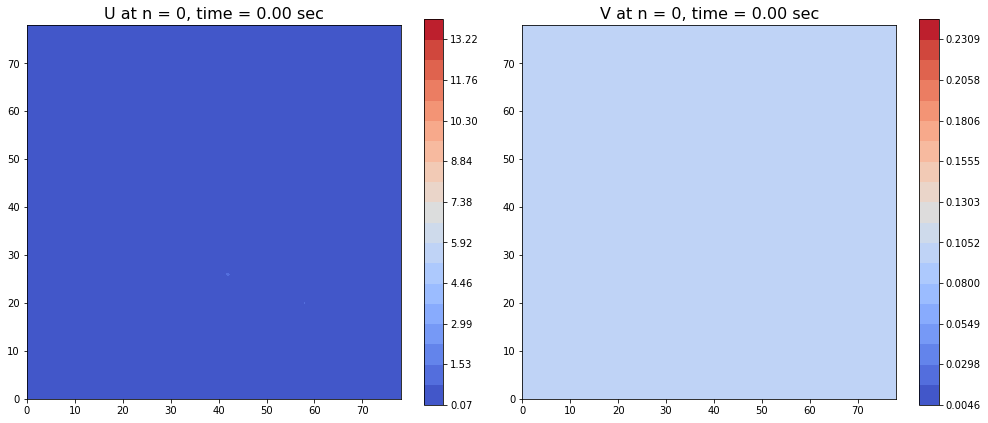

In [5]:
ani = animate_pattern(U2d, V2d, h, dt, Nsteps=time_steps, Nout=50)
HTML(ani.to_html5_video())

## Crank Nicolson Method

In [6]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - 0.5 * Du * c * L
Tv = sparse.eye(N) - 0.5 * Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
np.random.seed(9001)
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

# CN Method
for i in range(1, time_steps):
    bU = (0.5 * Du * c) * L.dot(U1d[i - 1]) \
    + dt * rho/V1d[i - 1] * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_u) * U1d[i - 1] + dt * rho_u
    U1d[i] = solve_Tu(bU)

    bV = (0.5 * Dv * c) * L.dot(V1d[i - 1]) \
    + dt * rho * U1d[i - 1]**2 / (1 + kappa*U1d[i - 1]**2) + (1 - dt * mu_v) * V1d[i - 1]
    V1d[i] = solve_Tv(bV)

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

dt = 20, time_steps = 500


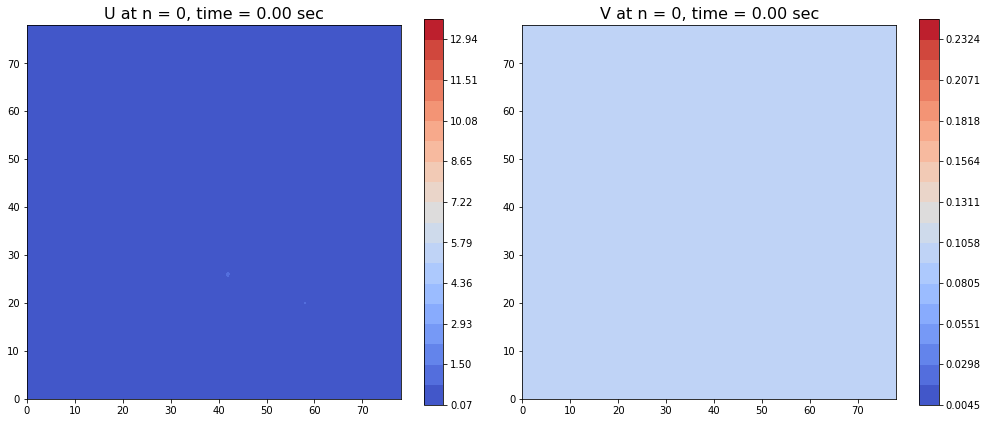

In [7]:
ani = animate_pattern(U2d, V2d, h, dt, Nsteps=time_steps, Nout=50)
HTML(ani.to_html5_video())

## Alternating Direction Implicit Method

In [8]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)


# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial condition
np.random.seed(9001)
U_init = np.random.normal(0.5, 0.1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

dt = 20, time_steps = 500


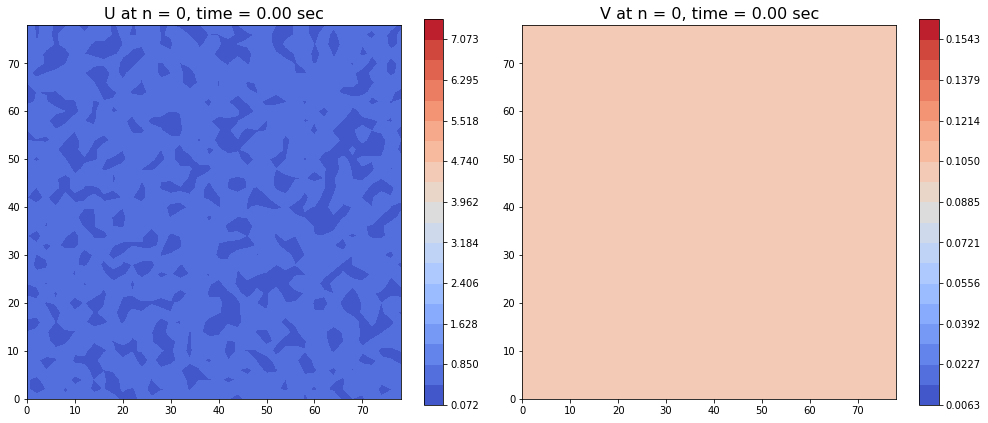

In [9]:
ani = animate_pattern(U, V, h, dt, Nsteps=time_steps, Nout=50)
HTML(ani.to_html5_video())